In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

In [31]:
np.min(r_sm),r[9]

(0.11, 0.11068899881814716)

In [248]:
TRES = 5
VRES = 3

year = 2017
month = 3
day = 5
hour = 15


def CalSys(year, month, day, hour, TRES=TRES, VRES=VRES, rlim=8, doshow=True):

    path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
    filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
    Mat_Spar = np.loadtxt(filename1)
    Mat_Sper = np.loadtxt(filename3)

    pix_r = np.squeeze(np.where(r >= rlim))[0]
    
    Spar = Mat_Spar[int((60./TRES)*hour),:]
    Sper = Mat_Sper[int((60./TRES)*hour),:]

    r_sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[2]
    sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[3]

    f_sm = interp1d(r_sm, sm)

    sm_lidar = f_sm(r[int(10*3./VRES):])
    bm = f_sm(r[int(10*3./VRES):])/((8*np.pi/3)*1.0401)
    bm_par = 0.996*bm
    bm_per =0.00366*bm_par
    T2 = np.exp((-2*np.cumsum(sm_lidar)*(r[1]-r[0])))  

    Cpar_ = Spar[int(10*3./VRES):]/(bm_par*T2)
    Cper_ = Sper[int(10*3./VRES):]/(bm_per*T2)

    Cpar = np.nanmean(Cpar_[pix_r:])
    Cper = np.nanmean(Cper_[pix_r:])
    Cpar_std = np.nanstd(Cpar_[pix_r:])
    Cper_std = np.nanstd(Cper_[pix_r:])
    
    K = np.nanmedian((0.00366/(Sper/Spar)))

    if doshow == True:
        
        pylab.plot(r[int(10*3./VRES):],1/(bm_par*T2))
        pylab.plot(r[int(10*3./VRES):],1/(bm_per*T2))
        #pylab.axis([3,10,1,0.01])
        pylab.show()
        
        pylab.plot(r[:],Spar)
        pylab.plot(r[:],Sper)
        pylab.axis([3,10,1,1000])
        pylab.xlabel("Range [km]")
        pylab.ylabel("r2-corrected Signal")
        pylab.show()

        pylab.plot(r[:],0.00366/(((Sper))/(Spar)))
        pylab.axis([3,10,0,1])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Dep.Ratio")
        pylab.show()

        pylab.plot(r[int(10*3./VRES):][pix_r:],Cpar_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cpar")
        pylab.show()

        pylab.plot(r[int(10*3./VRES):][pix_r:],Cper_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cper")
        pylab.show()    
    
        print "Cpar = ", Cpar,'/std = ',Cpar_std,"Cper = ",Cper,'/std = ',Cper_std,"Cpar/Cper = ", Cpar/Cper
    return [[Cpar,Cper], [Spar, Sper], r, K]

#2017/02/25 14UTC
#2017/03/08 14UTC
#2017/03/13 14UTC
#2017/03/15 14UTC
#2017/03/18 14UTC

C1,P1,r,K1 = CalSys(year, 2, 25,14, TRES = 5, VRES = 3, doshow = False)
C3,P2,r,K2 = CalSys(year, 3, 8, 14, TRES = 5, VRES = 3, doshow = False)
C3,P3,r,K3 = CalSys(year, 3, 18, 13, TRES = 5, VRES = 3, doshow = False)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: divide by zero encountered in divide


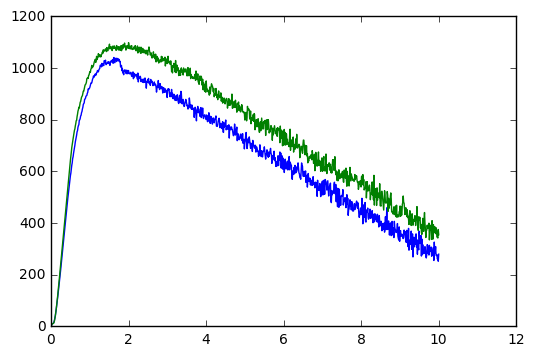

In [250]:
pylab.plot(r,P1[0])
pylab.plot(r,P2[0])
pylab.show()

In [244]:
print K1,K2,K3

0.210771465024 0.260020445485 0.227118545764


[295479.38326833793, 1283266.9893993114]
[387222.20356238307, 1856049.0951779026]
[244875.14589933, 1475818.3965653554]
0.230255578698 0.208627134147 0.165924985397


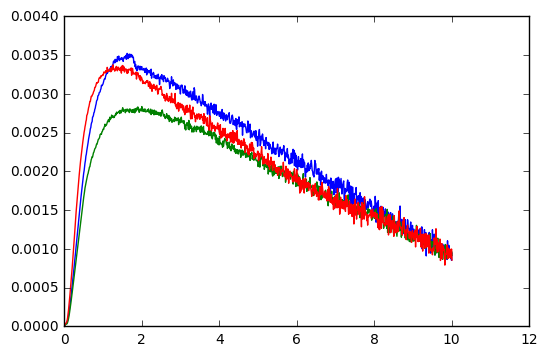

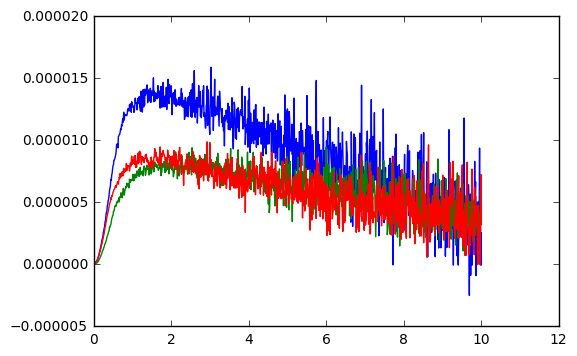

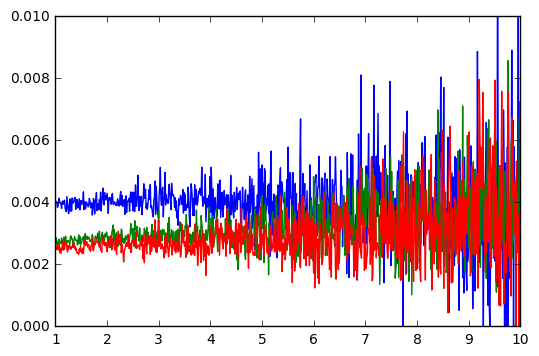

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in divide


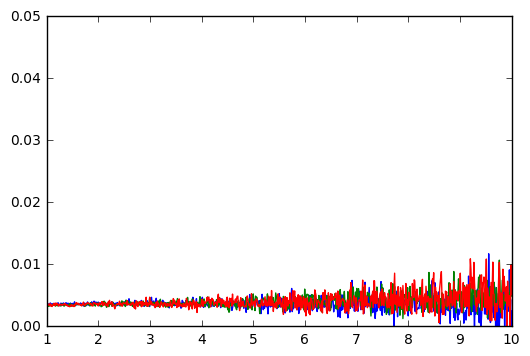

In [243]:
print Cal1[0]
print Cal2[0]
print Cal3[0]
print Cal1[0][0]/Cal1[0][1],Cal2[0][0]/Cal2[0][1],Cal3[0][0]/Cal3[0][1]

pylab.plot(Cal1[2][2],Cal1[2][0]/Cal1[0][0])
pylab.plot(Cal2[2][2],Cal2[2][0]/Cal2[0][0])
pylab.plot(Cal3[2][2],Cal3[2][0]/Cal3[0][0])
pylab.show()

pylab.plot(Cal1[2][2],Cal1[2][1]/Cal1[0][1])
pylab.plot(Cal2[2][2],Cal2[2][1]/Cal2[0][1])
pylab.plot(Cal3[2][2],Cal3[2][1]/Cal3[0][1])
pylab.show()

pylab.plot(Cal1[2][2],(Cal1[2][1]/Cal1[2][0])*(Cal1[0][0]/Cal1[0][1]))
pylab.plot(Cal2[2][2],(Cal2[2][1]/Cal2[2][0])*(Cal2[0][0]/Cal2[0][1]))
pylab.plot(Cal3[2][2],(Cal3[2][1]/Cal3[2][0])*(Cal3[0][0]/Cal3[0][1]))
pylab.axis([1,10,0,0.01])
pylab.show()

K1 = np.nanmedian((0.00366/(Cal1[2][1]/Cal1[2][0])))
K2 = np.nanmedian((0.00366/(Cal2[2][1]/Cal2[2][0])))
K3 = np.nanmedian((0.00366/(Cal3[2][1]/Cal3[2][0])))


pylab.plot(Cal1[2][2],K1*(Cal1[2][1]/Cal1[2][0]))
pylab.plot(Cal2[2][2],K2*(Cal2[2][1]/Cal2[2][0]))
pylab.plot(Cal3[2][2],K3*(Cal3[2][1]/Cal3[2][0]))
pylab.axis([1,10,0,0.05])
pylab.show()

In [66]:
Cpar =  331077.319291 /std =  21207.0732497 Cper =  2428318.65784 /std =  816402.273351 Cpar/Cper =  0.136340145566
Cpar =  337426.257255 /std =  9169.08627914 Cper =  2197662.30654 /std =  373970.868415 Cpar/Cper =  0.153538719871

1.0010188987384854